In [64]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from itertools import product, chain
import importlib

import trainer, data, models

In [132]:
importlib.reload(trainer)
importlib.reload(data)
importlib.reload(models)

<module 'models' from '/Users/ralph/projects/d2dl/models.py'>

In [133]:
kaggle_housing_dataset = data.kaggle_housing()

In [135]:
class LinearRegression(nn.Sequential):
    def __init__(self, hidden_dim: int = 100, num_outputs: int = 1):
        super().__init__(
            nn.LazyLinear(hidden_dim),
            nn.ReLU(),
            nn.LazyLinear(num_outputs)
        )

In [136]:
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))

In [137]:
provider = lambda hyperparams: trainer.Trainer(
    model=LinearRegression(hidden_dim=hyperparams.model["hidden_dim"], num_outputs=1),
    dataset=kaggle_housing_dataset,
    loss=RMSLELoss,
    opt=torch.optim.SGD,
    hyperparameters=hyperparams
)

In [138]:
model_trainer = provider(trainer.Hyperparameters(
    opt=dict(
        lr = 1e-3
    ),
    model=dict(
        hidden_dim = 100
    ),
    general=dict(
        num_epochs = 100,
        batch_size = 8
    )
))

/Users/ralph/.venvs/d2dl/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [139]:
train_result = model_trainer.train(10)

In [140]:
train_result

,train,val
0,11.935948,11.916979
1,12.084856,11.814901
2,11.653575,12.176263
3,11.978593,11.648433
4,11.602121,11.966024
...,...,...
395,10.021832,9.882076
396,9.807494,9.949915
397,9.670679,9.866084
398,9.704843,9.775716


<Axes: >

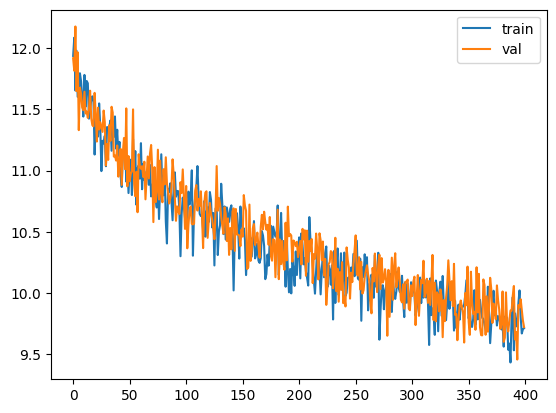

In [141]:
train_result.plot()

In [142]:
val_x = torch.stack([
    kaggle_housing_dataset.val[i][0]
    for i in range(len(kaggle_housing_dataset.val))
])

In [143]:
val_y = torch.stack([
    kaggle_housing_dataset.val[i][1]
    for i in range(len(kaggle_housing_dataset.val))
])

In [144]:
model_y = model_trainer.model(val_x)

In [145]:
val_df = pd.DataFrame(
    torch.stack([
        torch.flatten(model_y.detach()),
        torch.flatten(val_y)
    ], dim = 1),
    columns=["pred", "val"]
)

<Axes: xlabel='pred', ylabel='val'>

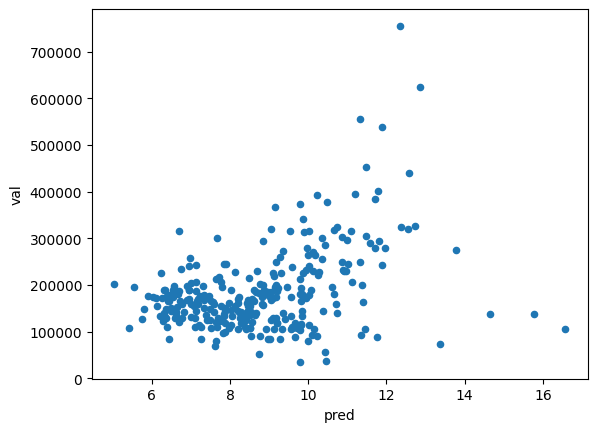

In [146]:
val_df.plot(kind="scatter", x="pred", y="val")